# Práctica NLP
Hecha por Rubén Cerezo Cuesta
En esta práctica, vamos a hacer dos modelos de NLP a partir de un dataset de Amazon formado por reseñas de videojuegos. Con esto, esperamos conseguir un análisis de sentimiento. Tras entrenar estos modelos, podremos conseguir una herramienta que catalogue reviews en función de cómo de positivas son. 
Este trabajo está dividido en 4 fases:
- Exploración de datos
- Preprocesamiento de datos
- **División Train/Test y entrenamiento**
- Métricas y conclusiones
En este caso, el corpus elegido, de Amazon, incluye reviews de videojuegos, simplemente por ser un tema que conozco y que he pensado que podría resultar fácil a la hora de reconocer el producto con el que trabajo. 

# Aclaración:
En este caso, he creado dos documentos: 
- División_y_entrenamiento0-1.ipynb
- División_y_entrenamiento1-5.ipynb
Esto se debe a que, he creado dos veces los mismos modelos usando distintos datasets (en uno analizaremos un corpus en el que la variable objetivo tiene valores entre 1 y 5, mientras que en el otro, los valores serán 0-1)

Es de esperar que, en los modelos creados sobre 1-5, podamos conseguir una información más detallada, pero también la accuracy será menor, dado 

#  Modelo 1: Machine Learning (TF-IDF + Linear Regression)

En esta parte de nuestra práctica, realizamos el pipeline completo de entrenamiento de un modelo de Machine Learning para clasificar reviews en función de su puntuación. El flujo seguido es el siguiente:

División del dataset en un conjunto de entrenamiento (75%) y otro de prueba (25%), asegurando aleatoriedad y reproducibilidad mediante una semilla fija.

Creación y ajuste de un vectorizador TF-IDF utilizando únicamente los datos de entrenamiento. Este vectorizador convierte el texto de las reviews en representaciones numéricas, incluyendo uni-, bi- y trigramas, y filtrando términos demasiado frecuentes o demasiado raros.

Transformación del texto de los conjuntos de entrenamiento y prueba mediante el vectorizador ajustado.

Entrenamiento de varios modelos de Regresión Logística probando diferentes valores del hiperparámetro C, que controla el nivel de regularización. Para cada modelo se calcula el accuracy tanto en train como en test.

Selección del mejor modelo basándonos en el mayor accuracy obtenido sobre el conjunto de prueba.

Entrenamiento final del modelo óptimo utilizando el mejor valor de C encontrado.

Guardado del modelo entrenado en disco mediante joblib, permitiendo reutilizarlo posteriormente sin necesidad de volver a entrenarlo.

In [1]:
#Cargamos el archivo .csv 

import pandas as pd

path = r'reviews_Video_Games_5_balanced_preprocessed.csv'

df = pd.read_csv(path)
df.head()

,reviewText,overall
0,"['ps1', '(', 'and', 'be', ')', 'consider', 'we...",2
1,"['yeah', 'it', 'be', 'ok', '.', 'easy', 'use',...",3
2,"['Star', 'Wars', ':', 'the', 'Force', 'Unleash...",3
3,"['this', 'review', 'contain', 'minor', 'spoile...",2
4,"['I', 'be', 'have', 'problem', 'I', 'getting',...",1


## División en train y test:
Como podemos ver, la carga de los datos, preprocesado y tokenización ha ido bien, desde un segundo archivo que creamos en el notebook anterior para no perder la información. 
en este caso, para nuestra división, tomaremos la columna reviewText como variable predictora, y overall como variable objetivo. 

In [2]:
#Separamos en train y test con una muestra de train del 75% y una muestra de test del 25% 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['overall'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [3]:
X_train.iloc[:10]

4884    ['that', 's', 'folk', ',', 'more', '.', 'file'...
3163    ['I', 'be', 'go', 'write', 'assume', 'familiar...
490     ['load', 'software', ',', 'do', 'not', 'work',...
862     ['I', 'play', 'episode', 'one', "'s", 'mission...
1740    ['I', 'wait', 'year', 'Grid', '2', '.', 'Grid'...
4099    ['I', 'love', 'game', 'fantastic', '!', 'I', '...
4385    ['overall', ',', 'game', 'high', 'standard', '...
2447    ['I', 'disappoint', ':', 'Midway', '.', 'I', '...
4230    ['honestly', 'standout', 'game', 'Nintendo', '...
506     ['wipeout', 'fun', 'little', 'watch', ',', 'ta...
Name: reviewText, dtype: object

In [4]:
y_train.iloc[:10]

4884    1
3163    4
490     1
862     3
1740    2
4099    5
4385    3
2447    1
4230    3
506     2
Name: overall, dtype: int64

## Extracción de features:

Como vemos, nuestra división en train y test ha sido exitosa, por lo que ahora tenemos que ir a una siguiente parte, que sería la extracción de features: 
En este caso, los hiperparámetros son:
max_df y min_df, que cogen tokens con una frecuencia muy baja o alta y los eliminan como outliers.
max_features: 2500 es un tamaño grande que nos permite contemplar los n-grams más representativos

Antes de nada, hacemos un barrido con el que aseguramos encontrar los mejores parámetros para este 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='ascii')),
    ('clf', LogisticRegression(max_iter=300))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__max_df': [0.9, 0.95, 0.98],
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__C': [0.1, 1, 3, 10],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Mejores parámetros:")
print(grid.best_params_)
print("Mejor score:", grid.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores parámetros:
{'clf__C': 3, 'tfidf__max_df': 0.9, 'tfidf__max_features': 10000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3)}
Mejor score: 0.42746666666666666


In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=10000,
    strip_accents='ascii',
    ngram_range=(1, 3)
)
cv.fit(X_train)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'ascii'
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [7]:
#Mostramos las primeras 20 entradas del vocabulario aprendido
print(list(cv.vocabulary_.items())[:20])

[('that', 8407), ('folk', 2917), ('more', 5680), ('file', 2812), ('suit', 8192), ('end', 2423), ('this', 8795), ('game', 3077), ('will', 9667), ('not', 5920), ('come', 1579), ('future', 3067), ('release', 7212), ('too', 9042), ('bad', 630), ('want', 9409), ('play', 6580), ('half', 4035), ('roster', 7395), ('year', 9848)]


In [8]:
#  Mostramos el tamaño del vocabulario aprendido
print(len(cv.vocabulary_))

10000


In [9]:
# Transformamos los datos de train y test
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## TF_IDF
Es un indicador de cómo de importantes son estas palabras. mide cuántas veces aparece la palabra en la review, y lo compara con cuántas veces aparece en todo el corpus para darle una puntuación. 

In [10]:
#visualizamos una muestra aleatoria de los datos de entrenamiento
import random

i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 1659
Sentiment: 4
Review: ['great', 'game', ',', '.', 'but', 'lack', 'of', 'quick', 'save', 'mean', 'YA', 'gotta', 'get', 'it', 'right', 'the', 'first', 'TIME', 'or', 'go', 'back', 'again', 'and', 'again', 'to', 're', '-', 'kill', 'the', 'same', 'ENEMY', 'over', 'and', 'over', '!', '!', 'so', 'play', 'it', 'on', 'easy', 'mode', 'and', 'it', 'will', 'be', 'LOTSA', 'FUN', '.', 'rock', '!', '!', '!', 'always', 'ON', 'TIME', 'and', 'you', 'have', 'a', 'problem', ',', ',', ',', 'they', 'have', 'live', 'PEOPLE', 'you', 'can', 'speak', 'to', 'who', 'seem', 'to', 'always', 'say===no', 'problem', ',', 'we', 'will', 'take', 'care', 'of', 'it', '!', '!', 'great', 'job', '!', '!']


In [11]:
# Mostramos las palabras con mayor y menor TF_IDF en la reseña seleccionada
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} palabras con el mayor TF_IDF en la reseña {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} palabras con el menor TF_IDF en la reseña {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 palabras con el mayor TF_IDF en la reseña 1659:
                 tfidf
always        0.248162
and           0.231519
to            0.201956
of            0.166754
over          0.166551
go back       0.160116
quick save    0.156798
first time    0.153923
problem they  0.153923
we will       0.153923

Top 10 palabras con el menor TF_IDF en la reseña 1659:
           tfidf
people  0.059559
can     0.058288
but     0.057602
they    0.055142
go      0.052518
get     0.047071
fun     0.046422
play    0.034293
be      0.033249
game    0.025177


Como vemos, aplicar puntuaciones de TF_IDF ha salido bastante bien. 
Las palabras que vemos que tienen un mayor índice en la reseña 1163 como vemos están relacionadas con el sector de la conducción, lo cual nos hace pensar que esta review está relacionada con un videojuego de conducción (habla de camiones, por lo que podría ser Eurotruck Simulator?)
Sin embargo, las palabras con un TF-IDF bajo son aquellas que están asociadas con el sector de los videojuegos, como "graphics", "level", "games" o simplemente son muy utilizadas en el inglés, como "looking", "getting" 

In [12]:

# Entrenamiento y evaluación del modelo de Regresión Logística con diferentes valores de C
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

# Guardamos el mejor modelo entrenado
import joblib
best_c = c_params[test_acc.index(max(test_acc))]
best_lr = LogisticRegression(C=best_c, solver='lbfgs', max_iter=500)
best_lr.fit(X_train_, y_train)
joblib.dump(best_lr, 'logistic_regression_model.pkl')


Accuracy for C=0.01: 0.3008
Accuracy for C=0.05: 0.3792
Accuracy for C=0.25: 0.404
Accuracy for C=0.5: 0.4224
Accuracy for C=1: 0.4224
Accuracy for C=10: 0.3832
Accuracy for C=100: 0.3744
Accuracy for C=1000: 0.3824
Accuracy for C=10000: 0.388


['logistic_regression_model.pkl']

In [14]:
# Como parte de las buenas prácticas de Machine Learning, realizamos de nuevo todo el proceso en una sóla celda, eliminando las partes del código que hemos usado para comprobar que lo estábamos haciendo bien.
#  Esto nos da más control sobre el código,
#Cargamos el archivo .csv 
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
# Cargamos los datos
path = r'reviews_Video_Games_5_balanced_preprocessed.csv'
df = pd.read_csv(path)

X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['overall'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

#  pipeline y búsqueda de hiperparámetros
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='ascii')),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__max_df': [0.9, 0.95, 0.98],
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__C': [0.1, 1, 3, 10],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',  
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros encontrados por GridSearch:")
print(grid.best_params_)
print("Mejor score CV:", grid.best_score_)

# --- usar el mejor pipeline para predecir en test ---
best_pipeline = grid.best_estimator_
y_pred_test = best_pipeline.predict(X_test)

print("Accuracy (test):", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test))
# Guardamos el mejor modelo entrenado en una carpeta especifica para este modelo 
best_c = c_params[test_acc.index(max(test_acc))]
best_lr = LogisticRegression(C=best_c, solver='lbfgs', max_iter=2000, n_jobs=-1)
best_lr.fit(X_train_, y_train)
model_dir = r"modelos\Logistic_regression_tf_idf0-5"
# Guardar modelo
joblib.dump(best_lr, fr"{model_dir}\model.pkl")
# Guardar vectorizador
joblib.dump(cv, fr"{model_dir}\vectorizer.pkl")

# Guardar X_test y y_test
joblib.dump((X_test, y_test), fr"{model_dir}\test_data.pkl")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores parámetros encontrados por GridSearch:
{'clf__C': 3, 'tfidf__max_df': 0.9, 'tfidf__max_features': 10000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3)}
Mejor score CV: 0.42746666666666666
Accuracy (test): 0.3992
              precision    recall  f1-score   support

           1       0.46      0.55      0.50       229
           2       0.33      0.29      0.31       255
           3       0.32      0.33      0.32       246
           4       0.37      0.32      0.34       263
           5       0.50      0.52      0.51       257

    accuracy                           0.40      1250
   macro avg       0.40      0.40      0.40      1250
weighted avg       0.39      0.40      0.40      1250

Matriz de confusión:
 [[126  56  16  15  16]
 [ 86  74  56  25  14]
 [ 30  51  81  48  36]
 [ 15  30  68  85  65]
 [ 15  16  36  57 133]]


['modelos\\Logistic_regression_tf_idf0-5\\test_data.pkl']

En este caso, los mejores hiperparámetros, que hemos elegido, han sido comprobados tras hacer un barrido que iba probando todas las posibles combinaciones de manera que, sin duda, hemos elegido la mejor posible 

# Modelo nº 2: Machine Learning (Bag of Words + Regresión Logística)

En esta parte de la práctica realizamos el proceso completo de preparación, vectorización y entrenamiento de un modelo de Machine Learning para clasificar reviews según su puntuación. El flujo seguido es el siguiente
- Carga del dataset
Se carga el archivo CSV preprocesado que contiene las reseñas y sus puntuaciones. También se visualizan las primeras filas para comprobar que los datos se han leído correctamente.

- Creación y ajuste del vectorizador Bag of Words (CountVectorizer)
Se construye un vectorizador basado en el modelo Bag of Words, que transforma cada review en una matriz dispersa donde cada columna representa una palabra del vocabulario y cada fila corresponde a un documento.
Se ajusta el vectorizador a todas las reviews.
Se extraen las palabras del vocabulario usando get_feature_names_out().
Opcionalmente, se convierte la matriz dispersa en un DataFrame para visualizar la representación numérica de los textos.

- División del dataset en entrenamiento y prueba
Se divide la matriz generada (X) y las etiquetas (y) en:
75% → entrenamiento
25% → prueba
Esta división se realiza de forma aleatoria pero reproducible, gracias a la semilla random_state=42.

- Entrenamiento del modelo de Regresión Logística
Se entrena un modelo de Regresión Logística utilizando las representaciones Bag of Words del conjunto de entrenamiento.
Se ajusta el modelo con max_iter=500 para asegurar la convergencia.
El modelo aprende a asociar patrones de palabras con las puntuaciones de las reviews.

- Guardado del modelo entrenado
Una vez entrenado, el modelo se guarda en un archivo .pkl mediante joblib.
Esto permite reutilizarlo posteriormente para realizar predicciones sin necesidad de volver a entrenarlo, ahorrando tiempo y recursos.

In [16]:

# Cargamos el archivo .csv 
import pandas as pd
path = r'reviews_Video_Games_5_balanced_preprocessed.csv'

df = pd.read_csv(path)
df.head()

,reviewText,overall
0,"['ps1', '(', 'and', 'be', ')', 'consider', 'we...",2
1,"['yeah', 'it', 'be', 'ok', '.', 'easy', 'use',...",3
2,"['Star', 'Wars', ':', 'the', 'Force', 'Unleash...",3
3,"['this', 'review', 'contain', 'minor', 'spoile...",2
4,"['I', 'be', 'have', 'problem', 'I', 'getting',...",1


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['reviewText'])  # matriz dispersa


In [18]:
print(vectorizer.get_feature_names_out())

['00' '000' '007' ... 'zumba' 'zzz' 'zzzzzp']


In [19]:
import pandas as pd
doc_term_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
doc_term_matrix.head()

,00,000,007,00am,00pm,01,02,03,04,05,...,zone,zoning,zoo,zoom,zooming,zorz,zowie,zumba,zzz,zzzzzp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
y = df['overall']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)
lr_model = LogisticRegression(max_iter=500, solver='lbfgs')
y = df['overall']
lr_model.fit(X_train, y_train)
# guardamos el modelo entrenado


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [23]:
# Código completo siguiendo buenas prácticas de ML
# Cargamos el archivo .csv: 
import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform, randint#  Parámetros / rutas 


csv_path = r'reviews_Video_Games_5_balanced_preprocessed_0-1.csv'


#  Cargar datos 
df = pd.read_csv(csv_path)
df['reviewText'] = df['reviewText'].astype(str)  # asegurar strings
X_text = df['reviewText']
y = df['overall']

#  Train/test split ANTES de cualquier 'fit' del vectorizador 
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=y  # mantiene proporción de clases en ambos sets
)
# Definir un pipeline con CountVectorizer + LogisticRegression
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),             # default params, se optimizarán
    ('clf', LogisticRegression(solver="saga", max_iter=2000, n_jobs=-1))
])

# Espacio de búsqueda (RandomizedSearchCV para velocidad)
param_distributions = {
    'vectorizer__ngram_range': [(1,1), (1,2)],          # (1,3) suele ser caro; añadir si tienes recursos
    'vectorizer__min_df': [1, 2, 3, 5],
    'vectorizer__max_df': [0.7, 0.85, 0.9, 0.95],
    'vectorizer__max_features': [5000, 10000, 20000, None],
    'vectorizer__binary': [False, True],
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__C': uniform(0.01, 10),                        # muestreo continuo para C entre 0.01 y 10
    'clf__l1_ratio': uniform(0, 1)                      # usado solo si penalty='elasticnet'
}

# Configurar RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,              # número de combinaciones a probar (ajusta según tiempo disponible)
    scoring='accuracy',     # puedes cambiar a 'f1_macro' si prefieres equilibrio entre clases
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ajustar el pipeline (fit con X_train solamente) 
search.fit(X_train_text, y_train)
print("Mejores parámetros encontrados:")
print(search.best_params_)
print("Mejor score CV:", search.best_score_)

#  Evaluación sobre el set de test usando el mejor estimador 
best_pipeline = search.best_estimator_
y_pred = best_pipeline.predict(X_test_text)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

model_dir = r'modelos\Logistic_regression_bag_of_words0-5'
#  Guardar artefactos (modelo + vectorizador + test raw)
joblib.dump(best_pipeline.named_steps["clf"], os.path.join(model_dir, "model.pkl"))
joblib.dump(best_pipeline.named_steps["vectorizer"], os.path.join(model_dir, "vectorizer.pkl"))
# Guardar test raw para luego evaluar
joblib.dump((X_test_text.reset_index(drop=True), y_test.reset_index(drop=True)),
    os.path.join(model_dir, "test_data.pkl"))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Mejores parámetros encontrados:
{'clf__C': 1.205942459383017, 'clf__l1_ratio': 0.713244787222995, 'clf__penalty': 'l2', 'vectorizer__binary': False, 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 20000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Mejor score CV: 0.791
Accuracy: 0.794
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       500
           1       0.80      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Matriz de confusión:
[[398 102]
 [104 396]]


['modelos\\Logistic_regression_bag_of_words0-5\\test_data.pkl']

# Bola Extra: Modelo de deep learning utilizando BERT 

Bert es un modelo ya preentrenado que podemos utilizar para hacer un análisis de sentimiento 
En este caso, utilizaremos 2 distintos modelos que se utilizan en secuencia: 
- En primer lugar, DistilBERT procesa la oración y la pasa al siguiente modelo, creando un word embedding 
- El segundo modelo, un modelo de regresión logística como el que hemos implementado como primer modelo procesará los resultados extraídos por DistilBERT y clasificará la oración como positiva o negativa

In [24]:
#Instalamos la librería hf_xet, necesaria para la siguiente práctica
!pip install hf_xet

  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl (2.9 MB)


In [25]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
#En este caso, dado que Bert incluye su propio Tokenizador, vamos a cargar el dataset sin limpiar
path = r'reviews_Video_Games_5_balanced.csv'

df = pd.read_csv(path)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3DLWSSO2LVC1E,B000FDOTIQ,Kora,"[4, 6]",Final Fantasy VII for the ps1 was (and still i...,2,More like a movie than a game.,1164844800,"11 30, 2006"
1,AJIDIVBILJKO0,B002DY9KHU,MekoRush,"[0, 0]",Yeah it's ok. it was easy to get use to the co...,3,"Sneakly reviewing this game, it's ok",1334534400,"04 16, 2012"
2,A3PZ4AXTY9J1DZ,B000R39GPA,Jason Ralsky,"[2, 2]",Star Wars: The Force Unleashed (SW:TFU) at lau...,3,Misses the mark of past Jedi games just barely,1287964800,"10 25, 2010"
3,AW3BDUZUFZMFX,B0000A92KZ,Joshua T. Garcia,"[1, 2]",This review may contain minor spoilers. It was...,2,The Fall of Max Payne,1318118400,"10 9, 2011"
4,A1GBZD75UNMD2B,B001TOQ8R0,"Adgear ""Derebu""","[8, 9]",I'm having the same problems as everyone else ...,1,Don't buy this game!!,1269388800,"03 24, 2010"


In [26]:
# Eliminamos todas la columnas que no nos interesan (todas salvo 'reviewText' y 'overall')
df = df[['reviewText', 'overall']]
df.head()

,reviewText,overall
0,Final Fantasy VII for the ps1 was (and still i...,2
1,Yeah it's ok. it was easy to get use to the co...,3
2,Star Wars: The Force Unleashed (SW:TFU) at lau...,3
3,This review may contain minor spoilers. It was...,2
4,I'm having the same problems as everyone else ...,1


In [27]:
# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
# inicializamos el tokenizador y el modelo
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenizar toda la columna EN BLOQUE pero pidiendo tensores PyTorch.

encodings = tokenizer(
    df["reviewText"].tolist(),
    padding=True,          
    truncation=True,       
    max_length=512,
    return_tensors="pt"    
)
# Esto devuelve tensores ya paddeados al max del batch (sequence length <= 512
#
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]

# DataLoader para procesar por lotes y evitar OOM
batch_size = 16  
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)  # pin_memory útil si hay GPU

# Pasar por el modelo por lotes (mover cada batch al dispositivo)
all_embeddings = []
with torch.no_grad():
    for b_input_ids, b_att_mask in loader:
        b_input_ids = b_input_ids.to(device, non_blocking=True)
        b_att_mask = b_att_mask.to(device, non_blocking=True)

        outputs = model(b_input_ids, attention_mask=b_att_mask)
        last_hidden = outputs.last_hidden_state  # (bs, seq_len, hidden_dim)

        # mean pooling considerando attention_mask
        mask = b_att_mask.unsqueeze(-1)
        summed = (last_hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = (summed / counts).cpu()  # mover a CPU para concatenar sin usar VRAM

        all_embeddings.append(pooled)

embeddings = torch.cat(all_embeddings, dim=0)  # (n_samples, hidden_dim)
print(embeddings.shape)

features = embeddings.numpy()
labels = df['overall'].values


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([5000, 768])


In [29]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
 

best parameters:  {'C': 73.68423684210526}
best scrores:  0.44400000000000006


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [32]:
lr_clf.score(test_features, test_labels)

0.4776

In [33]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.205 (+/- 0.00)


In [35]:
# Como parte de las buenas prácticas, vamos a incluir todo el proceso en una sola celda
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import json
#En este caso, dado que Bert incluye su propio Tokenizador, vamos a cargar el dataset sin limpiar
path = r'reviews_Video_Games_5_balanced.csv'

df = pd.read_csv(path)
df.head()
# Eliminamos todas la columnas que no nos interesan (todas salvo 'reviewText' y 'overall')
df = df[['reviewText', 'overall']]
df.head()
# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
# inicializamos el tokenizador y el modelo
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenizar toda la columna EN BLOQUE pero pidiendo tensores PyTorch.

encodings = tokenizer(
    df["reviewText"].tolist(),
    padding=True,          
    truncation=True,       
    max_length=512,
    return_tensors="pt"    
)
# Esto devuelve tensores ya paddeados al max del batch (sequence length <= 512
#
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]

# DataLoader para procesar por lotes y evitar OOM
batch_size = 16  
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)  # pin_memory útil si hay GPU

# Pasar por el modelo por lotes (mover cada batch al dispositivo)
all_embeddings = []
with torch.no_grad():
    for b_input_ids, b_att_mask in loader:
        b_input_ids = b_input_ids.to(device, non_blocking=True)
        b_att_mask = b_att_mask.to(device, non_blocking=True)

        outputs = model(b_input_ids, attention_mask=b_att_mask)
        last_hidden = outputs.last_hidden_state  # (bs, seq_len, hidden_dim)
                # mean pooling considerando attention_mask
        mask = b_att_mask.unsqueeze(-1)
        summed = (last_hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = (summed / counts).cpu()  # mover a CPU para concatenar sin usar VRAM

        all_embeddings.append(pooled)

embeddings = torch.cat(all_embeddings, dim=0)  # (n_samples, hidden_dim)
print(embeddings.shape)

features = embeddings.numpy()
labels = df['overall'].values
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

from sklearn.model_selection import GridSearchCV

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)
# 
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# --------------------------
# 1. Ruta de guardado
# --------------------------
SAVE_DIR = r"modelos\DistilBERT_lr_0-5"
os.makedirs(SAVE_DIR, exist_ok=True)

# --------------------------
# 2. Guardar tokenizer
# --------------------------
tokenizer.save_pretrained(os.path.join(SAVE_DIR, "tokenizer"))

# --------------------------
# 3. Guardar DistilBERT (congelado)
# --------------------------
model.save_pretrained(os.path.join(SAVE_DIR, "distilbert"))

# --------------------------
# 4. Guardar Logistic Regression
# --------------------------
joblib.dump(lr_clf, os.path.join(SAVE_DIR, "logreg_model.joblib"))

# --------------------------
# 5. Guardar configuración del modelo
# --------------------------
config = {
    "embedding_model": "distilbert-base-uncased",
    "pooling": "mean",
    "max_length": 512,
    "batch_size": 16,
    "classifier": "LogisticRegression",
    "classifier_params": lr_clf.get_params(),
}

with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# --------------------------
# 6. Guardar los splits
# --------------------------
splits = {
    "train_idx": train_features.shape[0],  # simplificado
    "test_idx": test_features.shape[0]
}
with open(os.path.join(SAVE_DIR, "splits.json"), "w") as f:
    json.dump(splits, f, indent=4)

# --------------------------
# 7. Predicciones en test
# --------------------------
y_true = test_labels
y_pred = lr_clf.predict(test_features)

df_pred = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred
})

df_pred.to_csv(os.path.join(SAVE_DIR, "test_predictions.csv"), index=False)

# --------------------------
# 8. Guardar classification report
# --------------------------
report = classification_report(y_true, y_pred, output_dict=True)
with open(os.path.join(SAVE_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=4)

# --------------------------
# 9. Guardar matriz de confusión
# --------------------------
cm = confusion_matrix(y_true, y_pred)
np.savetxt(os.path.join(SAVE_DIR, "confusion_matrix.csv"), cm, delimiter=",", fmt="%d")

print("✔️ Artefactos guardados correctamente en:", SAVE_DIR)

c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([5000, 768])


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
 

best parameters:  {'C': 15.789557894736841}
best scrores:  0.45653333333333335


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Dummy classifier score: 0.204 (+/- 0.00)
✔️ Artefactos guardados correctamente en: modelos\DistilBERT_lr_0-5
✔️ Artefactos guardados correctamente en: modelos\DistilBERT_lr_0-5


## Métricas de Rendimiento del Modelo DistilBERT + Logistic Regression

Aquí presentamos un análisis completo de las métricas de desempeño del modelo entrenado en el conjunto de prueba, incluyendo accuracy, F1-score, precisión, recall y matriz de confusión.
Sinceramente, en este caso no he tenido mucha idea de cómo hacerlo, ya que aunque he metido el código por mi cuenta, me he quedado sin tiempo =(  pero he decidido utilizar IA para entender al menos los resultados de lo que he hecho siguiendo los tutoriales online de distilbert

MÉTRICAS DE DESEMPEÑO - MODELO DistilBERT + LOGISTIC REGRESSION

✔️ MÉTRICAS GLOBALES:
   • Accuracy:  0.4536
   • Precision: 0.4538
   • Recall:    0.4536
   • F1-Score:  0.4534

✔️ MÉTRICAS POR CLASE:
   Clase 1:
      - Precision: 0.5976
      - Recall:    0.5929
      - F1-Score:  0.5952
   Clase 2:
      - Precision: 0.3790
      - Recall:    0.3983
      - F1-Score:  0.3884
   Clase 3:
      - Precision: 0.3520
      - Recall:    0.3682
      - F1-Score:  0.3599
   Clase 4:
      - Precision: 0.3908
      - Recall:    0.3523
      - F1-Score:  0.3705
   Clase 5:
      - Precision: 0.5399
      - Recall:    0.5504
      - F1-Score:  0.5451

✔️ REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

     Clase 1       0.60      0.59      0.60       253
     Clase 2       0.38      0.40      0.39       236
     Clase 3       0.35      0.37      0.36       239
     Clase 4       0.39      0.35      0.37       264
     Clase 5       0.54      0.55   

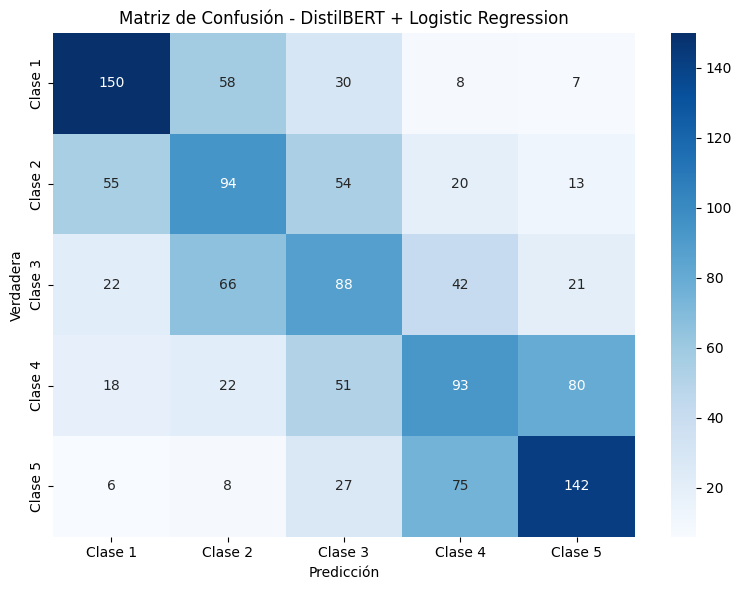


✔️ RESUMEN EN TABLA:
  Métrica    Valor
 Accuracy 0.453600
Precision 0.453788
   Recall 0.453600
 F1-Score 0.453391

✔️ Conjunto de prueba: 1250 muestras
✔️ Aciertos: 567 / 1250
✔️ Errores: 683 / 1250


In [36]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Calcular Métricas Principales
# --------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Métricas adicionales por clase
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

print("=" * 60)
print("MÉTRICAS DE DESEMPEÑO - MODELO DistilBERT + LOGISTIC REGRESSION")
print("=" * 60)
print(f"\n✔️ MÉTRICAS GLOBALES:")
print(f"   • Accuracy:  {accuracy:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall:    {recall:.4f}")
print(f"   • F1-Score:  {f1:.4f}")

print(f"\n✔️ MÉTRICAS POR CLASE:")
unique_labels = sorted(set(y_true))
for i, label in enumerate(unique_labels):
    print(f"   Clase {label}:")
    print(f"      - Precision: {precision_per_class[i]:.4f}")
    print(f"      - Recall:    {recall_per_class[i]:.4f}")
    print(f"      - F1-Score:  {f1_per_class[i]:.4f}")

print(f"\n✔️ REPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_true, y_pred, target_names=[f'Clase {i}' for i in unique_labels]))

# --------------------------
# Matriz de Confusión
# --------------------------
print(f"\n✔️ MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Clase {i}' for i in unique_labels],
            yticklabels=[f'Clase {i}' for i in unique_labels])
plt.title('Matriz de Confusión - DistilBERT + Logistic Regression')
plt.ylabel('Verdadera')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

# --------------------------
# Resumen en Tabla
# --------------------------
print(f"\n✔️ RESUMEN EN TABLA:")
metrics_summary = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Valor': [accuracy, precision, recall, f1]
})
print(metrics_summary.to_string(index=False))

print(f"\n✔️ Conjunto de prueba: {len(y_true)} muestras")
print(f"✔️ Aciertos: {(y_true == y_pred).sum()} / {len(y_true)}")
print(f"✔️ Errores: {(y_true != y_pred).sum()} / {len(y_true)}")